In [2]:
import cupy as cp
import cv2
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
# from utils import PG

In [3]:
def lpf(img, ncutoff):
    # Apply 2D FFT to the image
    f = cp.fft.fft2(img)

    # Shift the zero frequency component to the center of the spectrum
    fshift = cp.fft.fftshift(f)

    # Create a circular mask of the same size as the spectrum
    rows, cols = img.shape
    crow, ccol = rows // 2, cols // 2
    mask = np.zeros((rows, cols), np.uint8)
    cutoff = int(min(crow, ccol) * ncutoff)
    cv2.circle(mask, (ccol, crow), cutoff, 1, -1)
    # cv2.ellipse(mask, (ccol, crow), (1, 2) * cutoff, 0, 0, 360,  1, -1)

    mask = cp.asarray(mask)

    # Apply the mask to the shifted spectrum
    fshift_filtered = fshift * mask

    # Shift the zero frequency component back to the corner of the spectrum
    f_filtered = cp.fft.ifftshift(fshift_filtered)

    # Apply the inverse 2D FFT to the filtered spectrum
    img_filtered = cp.fft.ifft2(f_filtered)
    img_filtered = cp.real(img_filtered)

    return img_filtered

In [85]:
def pg(zed_depth, vlp_depth, ncutoff, threshold=100):
    mask = ~cp.isnan(vlp_depth)
    filtered = zed_depth
    filtered[mask] = vlp_depth[mask]

    while threshold > 0:
        filtered = lpf(filtered, ncutoff)
        filtered[mask] = vlp_depth[mask]

        threshold -= 1

    return filtered

In [54]:
vlp_depth = cp.load('vlp_depth.npy')
zed_depth = cp.load('zed_depth.npy')
pg_depth = cp.load('pg_depth.npy')

In [6]:
from sklearn.metrics.pairwise import cosine_similarity, cosine_distances

# Flatten the images
vec1 = pg_depth.get().flatten().reshape(1, -1)
vec2 = zed_depth.get().flatten().reshape(1, -1)

# Compute cosine similarity
print("Cosine similarity:", cosine_similarity(vec1, vec2))
print("Cosine distance:", cosine_distances(vec1, vec2))


ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

In [56]:
vlp_depth.size

921600

In [55]:
vlp_depth[vlp_depth != 0].size

921600

In [59]:
vlp_depth[cp.isinf(vlp_depth)].size

0

In [58]:
vlp_depth[cp.isnan(vlp_depth)].size

902413

In [96]:
vlp_depth_filled = vlp_depth.copy()
vlp_depth_filled[cp.isnan(vlp_depth_filled)] = 0
vlp_depth_filled[cp.isinf(vlp_depth_filled)] = 0

In [97]:
vlp_depth_filled.max()

array(99.36416, dtype=float32)

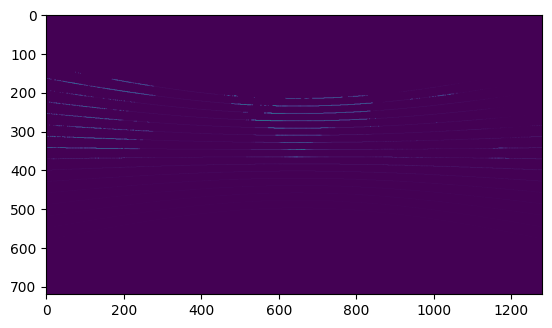

In [98]:
plt.imshow(vlp_depth_filled.get())

In [99]:
zed_depth.size

921600

In [62]:
zed_depth[cp.isinf(zed_depth)].size

69667

In [18]:
zed_depth[cp.isnan(zed_depth)].size

428794

In [32]:
zed_depth[cp.isnan(zed_depth)] = 0
zed_depth[cp.isinf(zed_depth)] = 0

In [63]:
zed_depth.max()

array(nan, dtype=float32)

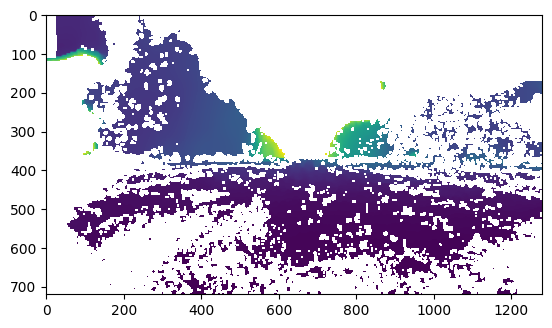

In [65]:
plt.imshow(zed_depth.get())

In [73]:
import cupy as cp
import cupyx.scipy.ndimage

def fast_fill_nan(img, iterations=10, connectivity=4):
    """
    Fill NaN values in a CuPy array using neighborhood averaging.
    """
    assert connectivity in (4, 8), "Connectivity must be 4 or 8"

    kernel = cp.array([[0, 1, 0],
                       [1, 0, 1],
                       [0, 1, 0]], dtype=cp.float32) if connectivity == 4 else cp.array([[1, 1, 1],
                                                                                           [1, 0, 1],
                                                                                           [1, 1, 1]], dtype=cp.float32)

    img_filled = img.copy()
    nan_mask = cp.isnan(img_filled)
    img_filled[nan_mask] = 0

    for _ in range(iterations):
        valid_mask = ~cp.isnan(img_filled)

        neighbor_count = cupyx.scipy.ndimage.convolve(valid_mask.astype(cp.float32), kernel, mode='constant', cval=0)
        neighbor_sum = cupyx.scipy.ndimage.convolve(img_filled, kernel, mode='constant', cval=0)

        avg_neighbors = cp.where(neighbor_count > 0, neighbor_sum / neighbor_count, 0)

        update_mask = cp.isnan(img_filled) & (neighbor_count > 0)
        img_filled[update_mask] = avg_neighbors[update_mask]

    return img_filled

In [89]:
zed_depth_filled = zed_depth.copy()
zed_depth_filled[cp.isinf(zed_depth_filled)] = cp.nan
mask_zed_nan = cp.isnan(zed_depth_filled)
zed_depth_filled = fast_fill_nan(zed_depth_filled)

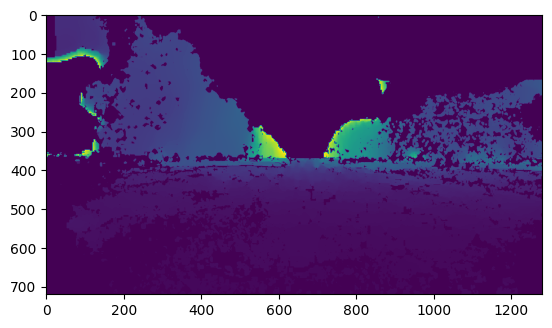

In [83]:
plt.imshow(zed_depth_filled.get())

In [70]:
zed_depth_filled.size

921600

In [84]:
zed_depth_filled[cp.isinf(zed_depth_filled)].size

0

In [90]:
pg_depth_new = pg(zed_depth_filled.copy(), vlp_depth.copy(), ncutoff=0.4, threshold=50)
pg_depth_new[mask_zed_nan] = cp.nan

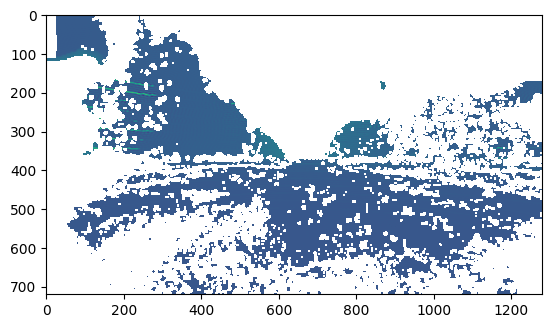

In [91]:
plt.imshow(pg_depth_new.get())

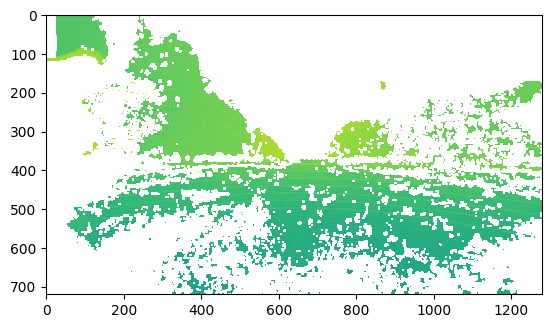

In [92]:
plt.imshow(cp.log(pg_depth_new).get())

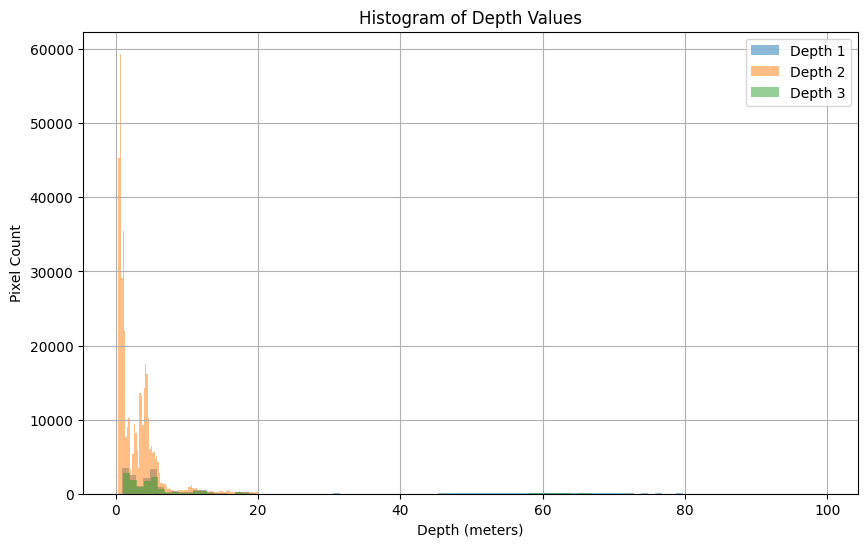

In [95]:

# Flatten and remove NaN/inf/zero for clean histograms
def preprocess_depth(depth):
    depth = depth.flatten()
    depth = depth[np.isfinite(depth)]
    depth = depth[depth > 0]  # remove zeros if they represent invalid depth
    return depth

d1 = preprocess_depth(vlp_depth.get())
d2 = preprocess_depth(zed_depth.get())
d3 = preprocess_depth(pg_depth.get())

# Plot histograms
plt.figure(figsize=(10, 6))
plt.hist(d1, bins=100, alpha=0.5, label='Depth 1')
plt.hist(d2, bins=100, alpha=0.5, label='Depth 2')
plt.hist(d3, bins=100, alpha=0.5, label='Depth 3')
plt.xlabel("Depth (meters)")
plt.ylabel("Pixel Count")
plt.title("Histogram of Depth Values")
plt.legend()
plt.grid(True)
plt.show()